In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [ ]:
data1 = {
    'student_id': [1, 2, 3, 4, 5],
    'age': [20, 21, 19, 22, 20],
    'gender': ['Male', 'Female', 'Male', 'Female', 'Male'],
    'major': ['Computer Science', 'Mechanical Engineering', 'Environmental Science', 'Civil Engineering', 'Electrical Engineering'],
    'year': [3, 2, 1, 4, 2],
    'region': ['West Bengal', 'Delhi', 'Karnataka', 'Maharashtra', 'West Bengal']
}

df1 = pd.DataFrame(data1)

data2 = {
    'student_id': [1, 2, 3, 4, 5],
    'logins_per_week': [5, 3, 7, 2, 6],
    'videos_watched': [12, 8, 15, 5, 10],
    'time_spent_on_platform (hrs)': [8, 4, 12, 3, 9],
    'avg_quiz_score': [85, 70, 90, 65, 80]
}

df2 = pd.DataFrame(data2)

df_merged = pd.merge(df1, df2, on='student_id')

data3 = {
    'student_id': [1, 2, 3, 4, 5],
    'courses_completed': [3, 1, 4, 2, 3],
    'courses_started': [5, 4, 6, 5, 5],
    'avg_score_across_courses': [80, 65, 88, 72, 78]
}

df3 = pd.DataFrame(data3)

df_final = pd.merge(df_merged, df3, on='student_id')

In [ ]:
df_final.head()

,student_id,age,gender,major,year,region,logins_per_week,videos_watched,time_spent_on_platform (hrs),avg_quiz_score,courses_completed,courses_started,avg_score_across_courses
0,1,20,Male,Computer Science,3,West Bengal,5,12,8,85,3,5,80
1,2,21,Female,Mechanical Engineering,2,Delhi,3,8,4,70,1,4,65
2,3,19,Male,Environmental Science,1,Karnataka,7,15,12,90,4,6,88
3,4,22,Female,Civil Engineering,4,Maharashtra,2,5,3,65,2,5,72
4,5,20,Male,Electrical Engineering,2,West Bengal,6,10,9,80,3,5,78


In [ ]:
np.random.seed(42)
num_synthetic = 50000
synthetic_data = {
    'student_id': np.arange(df_final['student_id'].max() + 1, df_final['student_id'].max() + 1 + num_synthetic),
    'age': np.random.randint(df_final['age'].min(), df_final['age'].max() + 1, num_synthetic),
    'gender': np.random.choice(df_final['gender'].unique(), num_synthetic),
    'major': np.random.choice(df_final['major'].unique(), num_synthetic),
    'year': np.random.randint(df_final['year'].min(), df_final['year'].max() + 1, num_synthetic),
    'region': np.random.choice(df_final['region'].unique(), num_synthetic),
    'logins_per_week': np.random.randint(df_final['logins_per_week'].min(), df_final['logins_per_week'].max() + 1, num_synthetic),
    'videos_watched': np.random.randint(df_final['videos_watched'].min(), df_final['videos_watched'].max() + 1, num_synthetic),
    'time_spent_on_platform (hrs)': np.random.randint(df_final['time_spent_on_platform (hrs)'].min(), df_final['time_spent_on_platform (hrs)'].max() + 1, num_synthetic),
    'avg_quiz_score': np.random.randint(df_final['avg_quiz_score'].min(), df_final['avg_quiz_score'].max() + 1, num_synthetic),
    'courses_completed': np.random.randint(df_final['courses_completed'].min(), df_final['courses_completed'].max() + 1, num_synthetic),
    'courses_started': np.random.randint(df_final['courses_started'].min(), df_final['courses_started'].max() + 1, num_synthetic),
    'avg_score_across_courses': np.random.randint(df_final['avg_score_across_courses'].min(), df_final['avg_score_across_courses'].max() + 1, num_synthetic)
}

df_synthetic = pd.DataFrame(synthetic_data)

def add_noise(column, noise_factor=0.5):
    return column * (1 + noise_factor * np.random.randn(len(column)))

numeric_cols = ['age', 'logins_per_week', 'videos_watched', 'time_spent_on_platform (hrs)', 'avg_quiz_score', 'courses_completed', 'courses_started', 'avg_score_across_courses']

for col in numeric_cols:
    df_synthetic[col] = add_noise(df_synthetic[col])

for col in numeric_cols:
    n_outliers = int(0.01 * num_synthetic)
    outliers_indices = np.random.choice(df_synthetic.index, n_outliers, replace=False)
    df_synthetic.loc[outliers_indices, col] = df_synthetic[col].max() * 10  # Extreme outliers (10x max value)

df_final_extended = pd.concat([df_final, df_synthetic], ignore_index=True)
df_final_extended.head()


,student_id,age,gender,major,year,region,logins_per_week,videos_watched,time_spent_on_platform (hrs),avg_quiz_score,courses_completed,courses_started,avg_score_across_courses
0,1,20.0,Male,Computer Science,3,West Bengal,5.0,12.0,8.0,85.0,3.0,5.0,80.0
1,2,21.0,Female,Mechanical Engineering,2,Delhi,3.0,8.0,4.0,70.0,1.0,4.0,65.0
2,3,19.0,Male,Environmental Science,1,Karnataka,7.0,15.0,12.0,90.0,4.0,6.0,88.0
3,4,22.0,Female,Civil Engineering,4,Maharashtra,2.0,5.0,3.0,65.0,2.0,5.0,72.0
4,5,20.0,Male,Electrical Engineering,2,West Bengal,6.0,10.0,9.0,80.0,3.0,5.0,78.0


In [ ]:
def course_completion_probability(student):
    score = np.random.uniform(-0.5, 0.5)

    if student['logins_per_week'] >= 4:
        score += 0.8

    if student['videos_watched'] >= 10:
        score += 1.2

    if student['time_spent_on_platform (hrs)'] >= 8:
        score += 1.5

    if student['avg_quiz_score'] >= 80:
        score += 1

    course_completion_rate = student['courses_completed'] / (student['courses_started'] + 1e-5)
    if course_completion_rate >= 0.75:
        score += 1.3

    if student['avg_quiz_score'] > 75 and student['avg_score_across_courses'] > 70:
        score += 1.6

    random_factor = np.random.uniform(0, 1)
    if random_factor < 0.2:
        score -= 2.0

    probability = 1 / (1 + np.exp(-score))

    if probability >= 0.5:
        return 1
    else:
        return 0

df_final_extended['will_complete_course'] = df_final_extended.apply(course_completion_probability, axis=1)


In [ ]:
df_final_extended.head()

,student_id,age,gender,major,year,region,logins_per_week,videos_watched,time_spent_on_platform (hrs),avg_quiz_score,courses_completed,courses_started,avg_score_across_courses,will_complete_course
0,1,20.0,Male,Computer Science,3,West Bengal,5.0,12.0,8.0,85.0,3.0,5.0,80.0,1
1,2,21.0,Female,Mechanical Engineering,2,Delhi,3.0,8.0,4.0,70.0,1.0,4.0,65.0,0
2,3,19.0,Male,Environmental Science,1,Karnataka,7.0,15.0,12.0,90.0,4.0,6.0,88.0,1
3,4,22.0,Female,Civil Engineering,4,Maharashtra,2.0,5.0,3.0,65.0,2.0,5.0,72.0,0
4,5,20.0,Male,Electrical Engineering,2,West Bengal,6.0,10.0,9.0,80.0,3.0,5.0,78.0,1


In [ ]:
df_final_extended['will_complete_course'].value_counts()

,count
will_complete_course,
1,45557
0,4448


In [ ]:
numeric_columns = [0,1,4,6,7,8,9,10,11,12]

In [ ]:
categorical_columns = [2,3,5]

In [ ]:
data = df_final_extended
X = data.drop('will_complete_course', axis=1)
y = data['will_complete_course']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
    ])

xgb_clf = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss')
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb_clf)])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Test set accuracy: {accuracy:.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:56:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Test set accuracy: 0.9167


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9167
Precision: 0.9303
Recall: 0.9816
F1-Score: 0.9553


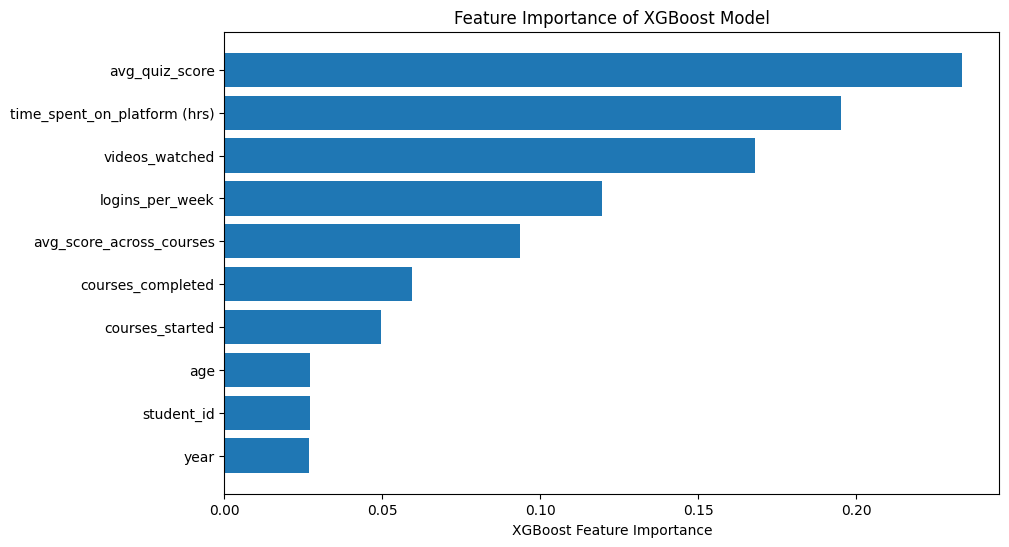

In [ ]:
import matplotlib.pyplot as plt

best_model = grid_search.best_estimator_.named_steps['classifier']
importance = best_model.feature_importances_
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist()

# Sort and plot feature importance
sorted_idx = importance.argsort()
plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx], importance[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("Feature Importance of XGBoost Model")
plt.show()
